# Processing and Analysis of Raster Data

In the first part of our lesson, we reviewed the basics of raster files and explored how to read and work with both single-band and multiband raster files, as well as retrieve raster images via WMS. Now, in the second part of the lesson, we will focus on how to process and analyze raster data. Specifically, we will cover:

- Merging multiple raster files to create a `raster mosaic`
- Clipping rasters using a polygon
- Reclassifying raster data
- Performing `slope` analysis

We will continue using the elevation model data provided by the [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/datasets-and-interfaces/product-descriptions/elevation-model-2-m). This time, we will work with all four raster tiles (L4133A, L4133B, L4133C, L4133D), which cover parts of Helsinki's city center. These tiles have already been downloaded to the `data` directory and will be used in this lesson.

Now let's read all four raster tiles and visualize them using subplots.   

In [1]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import rioxarray
import matplotlib.pyplot as plt

# Load the rasters and reproject them to EPSG:3067
raster1 = rioxarray.open_rasterio(DATA_DIRECTORY / 'L4133A.tif')
raster2 = rioxarray.open_rasterio(DATA_DIRECTORY / 'L4133B.tif')
raster3 = rioxarray.open_rasterio(DATA_DIRECTORY / 'L4133C.tif')
raster4 = rioxarray.open_rasterio(DATA_DIRECTORY / 'L4133D.tif')

In [3]:
# Check the CRS and make sure they are matching
print(raster1.rio.crs)
assert raster1.rio.crs == raster2.rio.crs == raster3.rio.crs == raster4.rio.crs

EPSG:3067


Let's map the raster files we just imported: 

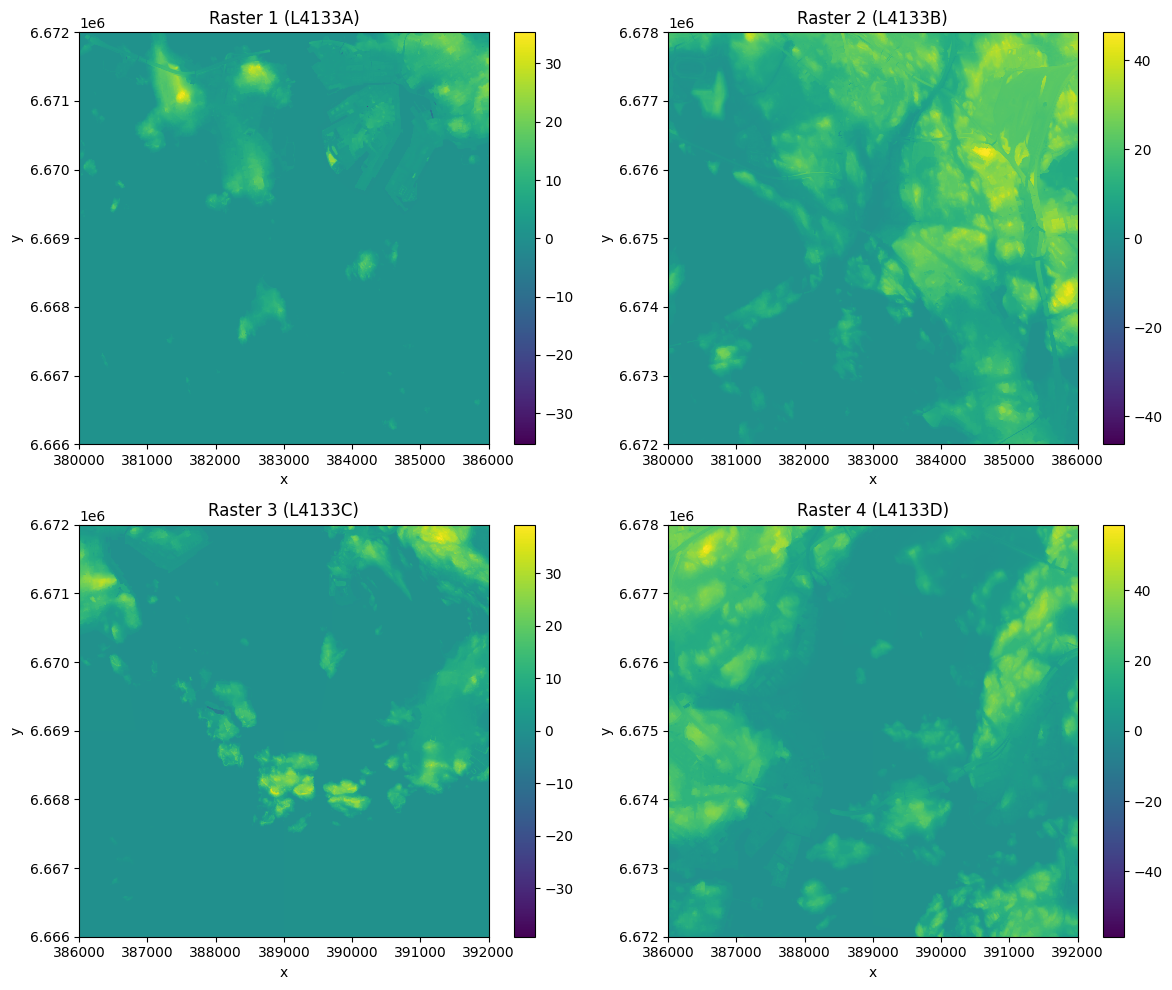

In [4]:
# Create a subplot with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each raster in a separate subplot
raster1.plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Raster 1 (L4133A)')

raster2.plot(ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title('Raster 2 (L4133B)')

raster3.plot(ax=axes[1, 0], cmap='viridis')
axes[1, 0].set_title('Raster 3 (L4133C)')

raster4.plot(ax=axes[1, 1], cmap='viridis')
axes[1, 1].set_title('Raster 4 (L4133D)')

# Adjust layout
plt.tight_layout()
plt.show()

<div style="border-left: 4px solid #f39c12; background-color: #fdf6e3; padding: 15px; margin: 20px 0;">
    <strong>Note:</strong> We are again using <code>matplotlib</code> for visualization of our raster datasets. Everything we’ve previously learned about visualization with <code>matplotlib</code> and styling still applies here. We have extensively used <code>matplotlib</code> during the 
    <a href="https://geo-python-site.readthedocs.io/en/latest/lessons/L7/python-plotting.html" target="_blank">GeoPython Lesson 7</a> and throughout this course, especially in 
    <a href="https://autogis-site.readthedocs.io/en/latest/lessons/lesson-5/static-maps.html" target="_blank">Lesson 5</a> where we focused on creating static maps.
</div>


As you can see, the four raster tiles cover adjacent areas in the Helsinki city center. However, they are still separate files! In the next step, we will merge these tiles into a single raster mosaic, creating a unified representation that covers the entire area.

### Create raster mosaic 

Raster files are usualy large in size, therefor it is quite common for providers to publish them in smaller pieces or tiles. While this makes it easier to transfer the data, it may not be so practical when it comes to the actual analysis. For example, as seen above, the elevation model from center of Helsinki is divided into 4 separate raster files. 

Now we want to merge multiple raster files together and create a raster mosaic. This can be done with the `merge_arrays()` -function in `rioxarray`. Now let's merge our data:

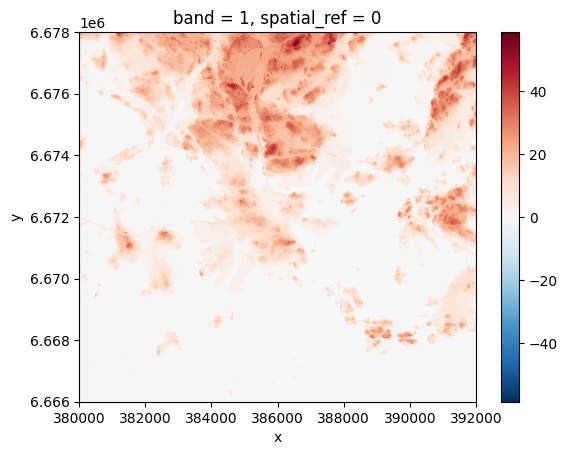

In [5]:
from rioxarray.merge import merge_arrays

# Merge the four raster data into one
mosaic_merged = merge_arrays([raster1, raster2, raster3, raster4])

# Save the merged raster (optional)
# mosaic_merged.rio.to_raster('merged_raster.tif')

# Plot the mosaic raster
mosaic_merged.plot()

### Clipping raster using a polygon

Clipping a raster using vector data (i.e., a polygon) is another common operation with raster data. In this part of lesson, we ¨will use WFS to get the administrative boundaries in Helsinki area. 

In [6]:
import geopandas as gpd

# Define the bounding box for Helsinki (EPSG:3067)
bbox_helsinki = "25400000,6670000,25500000,6680000"

# Fetch the Paavo data limited to the Helsinki area using WFS
paavo_data_helsinki = gpd.read_file(
    "https://geo.stat.fi/geoserver/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&typeName=postialue:pno"  # Adjust to the correct layer if needed
    "&srsName=EPSG:3879"
    f"&bbox={bbox_helsinki},EPSG:3879"
)

# Display the first few rows of the data
paavo_data_helsinki.head()

# Save to a file if needed
# paavo_data_helsinki.to_file("paavo_data_helsinki.gpkg", driver="GPKG")


,gml_id,id,objectid,posti_alue,vuosi,nimi,namn,kunta,kuntanro,pinta_ala,geometry
0,pno.1,1,1,00100,2025,Helsinki keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,091,91,2353278,"POLYGON ((25496638.898 6672477.679, 25496762.1..."
1,pno.2,2,2,00120,2025,Punavuori - Bulevardi,Rödbergen - Bulevarden,091,91,414010,"POLYGON ((25496316.740 6671953.498, 25496387.6..."
2,pno.3,3,3,00130,2025,Kaartinkaupunki,Gardesstaden,091,91,428960,"POLYGON ((25497213.040 6671964.915, 25497297.9..."
3,pno.4,4,4,00140,2025,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,091,91,931841,"MULTIPOLYGON (((25497601.542 6671195.418, 2549..."
4,pno.5,5,5,00150,2025,Punavuori - Eira - Hernesaari,Rödbergen - Eira - Ärtholmen,091,91,1367328,"MULTIPOLYGON (((25495892.616 6670428.430, 2549..."


Now we can use the contents of the column *posti_alue* (meaning postal area) to select a postal area of our choice. Let's try Kamppi in city center; we know that the postal code for Kamppi is `00100`.

<Axes: >

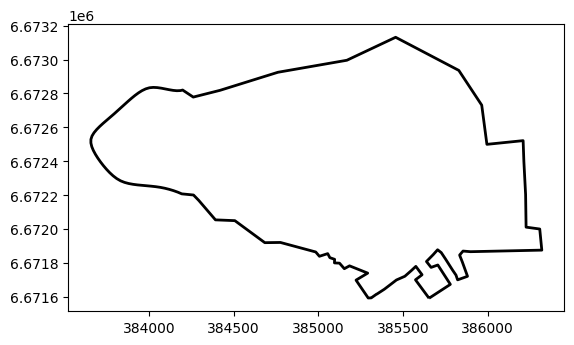

In [7]:
# Select Kamppi polygon based on postal code
kamppi = paavo_data_helsinki[paavo_data_helsinki['posti_alue'] == '00100']

# Transfrom the polygon to the same CRS as our raster data
kamppi = kamppi.to_crs(mosaic_merged.rio.crs)

kamppi.plot(facecolor='none', edgecolor='black', linewidth=2)

> **Note:**
> Similar to other map overlay analyses, it is essential to ensure that the CRS (Coordinate Reference System) of the raster files and the clipping feature are matching.

Once again, let's make sure that the CRS are matching and then let's proceed with the clipping. 

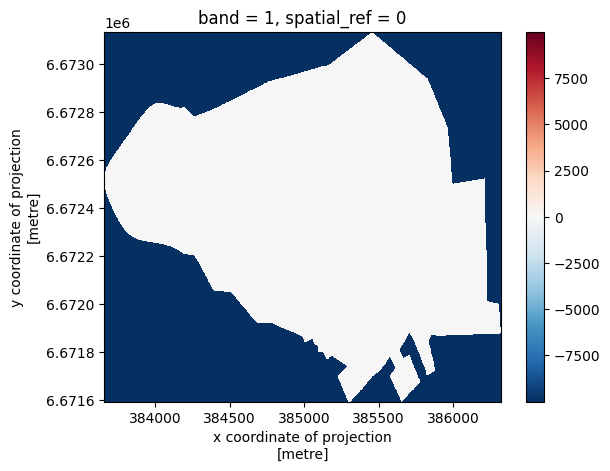

In [9]:
# Make sure that the CRS match
assert raster1.rio.crs == kamppi.crs , "CRS Mismatch"

# Clip the raster using the Kamppi polygon
clipped_mosaic = mosaic_merged.rio.clip(kamppi.geometry, kamppi.crs)

# Save the clipped raster (optional)
# clipped_mosaic.rio.to_raster("clipped_mosaic_kamppi.tif")

clipped_mosaic.plot()

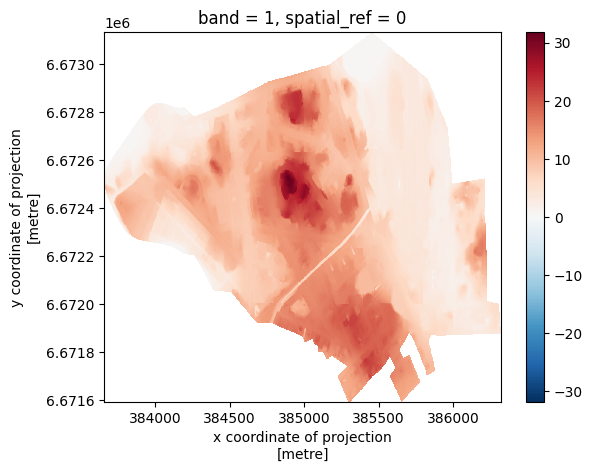

In [10]:
nodata_value = clipped_mosaic.rio.nodata

# Mask the NoData values
clipped_raster = clipped_mosaic.where(clipped_mosaic != nodata_value)
clipped_raster.plot()

> ### The function `np.where` in NumPy
> The **`np.where`** function in NumPy is a conditional function that allows you to select elements from an array based on a condition. It can be thought of as an element-wise if-else for arrays.
> 
> #### Basic Syntax
> ```python
> np.where(condition, x, y)
> ```
> - **`condition`**: A boolean array or condition that’s checked for each element.
> - **`x`**: The value (or array) to use when the condition is `True`.
> - **`y`**: The value (or array) to use when the condition is `False`.
>
> For each element, if the `condition` is `True`, `np.where` returns the corresponding value from `x`; otherwise, it returns the corresponding value from `y`.
> 
> #### Example
> Here's a simple example to clarify how it works:
> ```python
> import numpy as np
>
> arr = np.array([1, -2, 3, -4, 5])
> result = np.where(arr > 0, arr, 0)
> print(result)
> ```
> **Output:**
> ```
> [1, 0, 3, 0, 5]
> ```
> In this case:
> - The condition `arr > 0` checks if each element is positive.
> - Where the condition is `True` (for positive numbers), `np.where` returns the original `arr` value.
> - Where the condition is `False` (for negative numbers), it returns `0`.
> 
> #### Practical Uses
> `np.where` is often used for:
> - **Masking values** in an array (e.g., setting invalid values to NaN).
> - **Conditional selection** in data processing and filtering.
> - **Replacing values** in an array based on certain conditions.

## Raster reclassification

**Raster reclassification** is another common procedure with raster dataset. Raster reclassification is the process of assigning new values to the pixels of a raster dataset based on their existing values. This is often used to simplify or categorize continuous data, such as elevation or land cover, into distinct classes. For example, in an elevation map, reclassification can group different elevation ranges into categories like "low", "medium", and "high" altitude, making it easier to analyze or visualize the data for specific applications such as hazard assessment or land management.

let's first have a look at the range of values (altitudes) in our raster data:

In [11]:
# Check the data range
print(clipped_raster.min().values, clipped_raster.max().values)

-1.829 31.834


Now we want to reclassify our data using two approaches. First, let's do it manually using the `numpy` library.  So basically here, we are treating our pixel values as an `Array` and do the calculations accordingly. 

> **Note:**
> An **array** (such as those created by NumPy) is a multi-dimensional container for data, but it lacks metadata like coordinate labels or attributes. In contrast, an **xarray.DataArray** enhances the array by adding labeled dimensions, coordinates, and attributes, making it easier to work with multi-dimensional data, especially in geospatial and time-series contexts.


In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Define the bins and new class values
bins = [-10, 10, 20, np.inf]  # Bins for elevation
new_values = [1, 2, 3]  # Class values: 1 for Low, 2 for Mid, 3 for High

# Mask out NaN values before reclassification
masked_raster = np.where(~np.isnan(clipped_raster), clipped_raster, np.nan)

# Apply the reclassification
reclassified_raster = np.digitize(masked_raster, bins, right=True)

# Retain NaN values by ensuring they are not reclassified
reclassified_raster = np.where(~np.isnan(clipped_raster), reclassified_raster, np.nan)

# Convert to an xarray DataArray
reclassified_raster = xr.DataArray(
    reclassified_raster,
    dims=clipped_raster.dims,  # Keep the same dimensions
    coords=clipped_raster.coords,  # Retain the spatial coordinates
    attrs=clipped_raster.attrs  # Preserve the original attributes
)

Let's map our reclassified raster now:

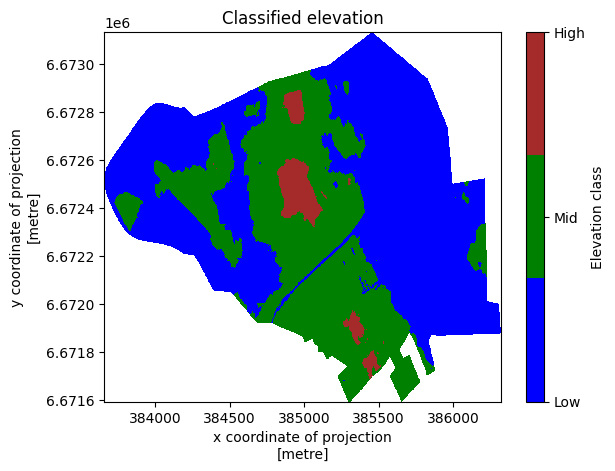

In [13]:
# Plot using xarray's plot method
plot = reclassified_raster.plot(cmap=plt.matplotlib.colors.ListedColormap(['blue', 'green', 'brown']))

# Set only the ticks [1, 2, 3] on the colorbar
colorbar = plot.colorbar
colorbar.set_ticks([1, 2, 3])
colorbar.set_ticklabels(['Low', 'Mid', 'High'])  # Rename the labels
colorbar.set_label("Elevation class")

plt.title("Classified elevation")
plt.show()

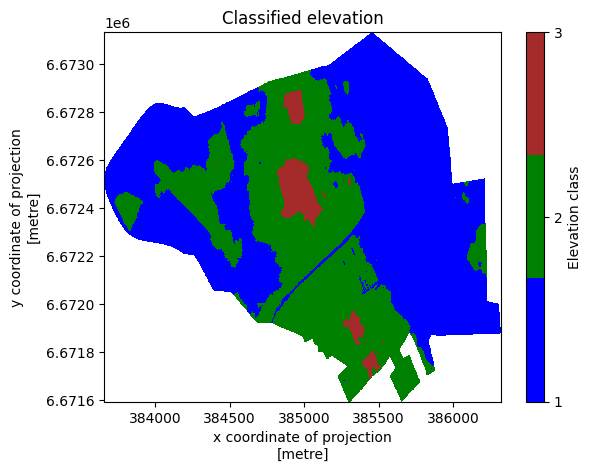

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Define the bins and new class values
bins = [-10, 10, 20, np.inf]  # Bins for elevation
new_values = [4, 5, 7]  # Class values: 1 for Low, 2 for Mid, 3 for High

# Mask out NaN values before reclassification
masked_raster = np.where(~np.isnan(clipped_raster), clipped_raster, np.nan)

# Apply the reclassification
reclassified_raster = np.digitize(masked_raster, bins, right=True)

# Retain NaN values by ensuring they are not reclassified
reclassified_raster = np.where(~np.isnan(clipped_raster), reclassified_raster, np.nan)

# Convert to an xarray DataArray
reclassified_raster = xr.DataArray(
    reclassified_raster,
    dims=clipped_raster.dims,  # Keep the same dimensions
    coords=clipped_raster.coords,  # Retain the spatial coordinates
    attrs=clipped_raster.attrs  # Preserve the original attributes
)

# Plot using xarray's plot method
plot = reclassified_raster.plot(cmap=plt.matplotlib.colors.ListedColormap(['blue', 'green', 'brown']))

# Set only the ticks [1, 2, 3] on the colorbar
colorbar = plot.colorbar
colorbar.set_ticks([1, 2, 3])
#colorbar.set_ticklabels(['Low', 'Mid', 'High'])  # Rename the labels
colorbar.set_label("Elevation class")

plt.title("Classified elevation")
plt.show()

We can also use the `mapclassify` library which we learned about in Lesson 4, to reclassify our raster. Let's Try *NaturalBreaks* method here.  

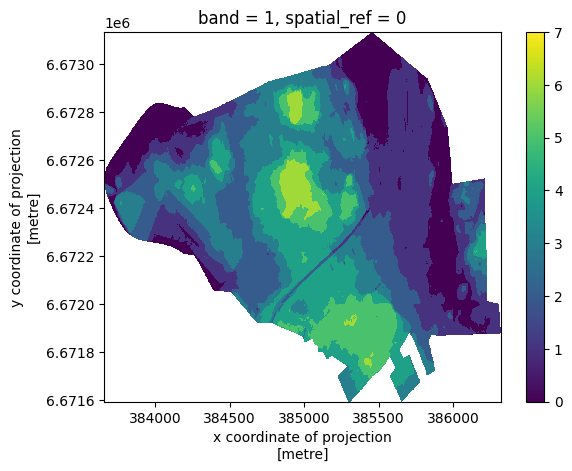

In [15]:
import numpy as np
import xarray as xr
import mapclassify

# Flatten the raster data and store the original shape
raster_data_flattened = clipped_raster.values.flatten()
original_shape = clipped_raster.shape

# Create a mask for NaN values and remove NaNs for classification
nan_mask = np.isnan(raster_data_flattened)
raster_data_no_nan = raster_data_flattened[~nan_mask]

# Apply Natural Breaks classification with 7 classes
natural_breaks = mapclassify.NaturalBreaks(raster_data_no_nan, k=7)

# Get the classified bins
breaks = natural_breaks.bins

# Classify the non-NaN raster values
classified_raster = np.digitize(raster_data_no_nan, bins=breaks)

# Create an array to hold the full reclassified data
reclassified_full_raster = np.full_like(raster_data_flattened, np.nan)

# Insert the classified data back, keeping NaNs in place
reclassified_full_raster[~nan_mask] = classified_raster

# Reshape the reclassified raster to its original shape
reclassified_full_raster = reclassified_full_raster.reshape(original_shape)

# Convert to xarray DataArray
reclassified_raster_nb = xr.DataArray(
    reclassified_full_raster,
    dims=clipped_raster.dims,
    coords=clipped_raster.coords,
    attrs=clipped_raster.attrs
)

# Plot the reclassified raster
reclassified_raster_nb.plot()

<div style="border: 2px solid #f39c12; padding: 15px; background-color: #fdf6e3;"> 
    <strong>Raster reclassification and NaN values</strong> <br>When reclassifying raster data, it's crucial to handle null values (NaNs) carefully. 
    If not properly masked, NaN values can be incorrectly classified, leading to erroneous results. Always ensure 
    that NaN values are treated appropriately to avoid classification issues.
</div>


## Slope analysis

**Slope analysis** is a key terrain analysis technique used in GIS and spatial analysis to measure the steepness or incline of the terrain at any given point. It is calculated by examining the rate of change in elevation between neighboring pixels in a digital elevation model (DEM). Slope analysis helps identify areas with steep gradients, which is useful in applications like land-use planning, erosion risk assessment, hydrological modeling, and infrastructure development. The slope is typically expressed in degrees or as a percentage.

Of course, we can perform slope analysis anywhere, including on the Helsinki city center raster we worked with earlier. However, for this course's purpose, it will be more interesting to calculate it for an area with more elevation variation. Since Finland is generally quite flat, we need to look further north to find terrain that is more elevation-wise interesting for slope analysis. For this purpose, we are heading to [Ylläs](https://en.wikipedia.org/wiki/Yll%C3%A4s) in Lapland, located in the northern part of Finland. Ylläs is a fell, or mountainous hill, and offers more diverse elevation changes, making it ideal for our slope analysis!

<div style="border-left: 4px solid #3498db; background-color: #f0f8ff; padding: 15px; margin: 20px 0;">
    <h3>About Ylläs</h3>
    <p>Ylläs is one of the highest fells in Finland, standing at 718 meters. It is located in the Pallas-Yllästunturi National Park and is a popular destination for outdoor activities such as hiking and skiing. Ylläs is known for its stunning natural landscapes, including vast forests, pristine lakes, and dramatic fells that rise above the surrounding terrain.</p>
    <img src="fig/yllas.jpg" alt="Raster Data Representation" style="max-width:100%; height:auto;">
    <p><em>Image Source: <a href="https://en.wikipedia.org/wiki/Yll%C3%A4s" target="_blank">Wikipedia - Ylläs</a> - <a href="https://www.metsa.fi/en/responsible-business/kiinteistokauppa-eng/business-sites/spectacular-yllas/" target="_blank">Metsähallitus</a></em></p>
</div>

The raster we will be working with is from the same source as the previous ones, provided by the [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/datasets-and-interfaces/product-descriptions/elevation-model-2-m), but from a different tile (`U4234`). We will calculate the slope using our clipped elevation raster. The slope at each point is derived by determining the rate of change in elevation between neighboring cells in the raster. This is done by:

1. **Gradient Calculation**: We use the elevation differences between adjacent cells in both the x (horizontal) and y (vertical) directions. The gradient represents how quickly elevation changes in these directions.
   
2. **Slope Formula**: The slope is calculated by combining these gradients using the Pythagorean theorem:
$$
\text{slope} = \sqrt{\left(\frac{\Delta z}{\Delta x}\right)^2 + \left(\frac{\Delta z}{\Delta y}\right)^2}
$$

where $ \Delta z $ is the change in elevation, and $ \Delta x $ and $ \Delta y $ are the distances between the cells in the x and y directions.


3. **Final Slope Values**: The result is often expressed in degrees or as a percentage, with steeper areas showing higher slope values. We use degrees here. 

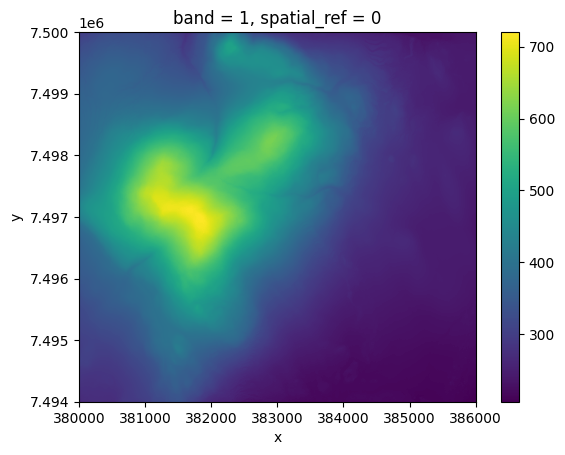

In [16]:
yllas_dem = rioxarray.open_rasterio(DATA_DIRECTORY /'U4234A.tif')
yllas_dem.plot()

In [17]:
# Get the pixel resolution
xres = yllas_dem.rio.resolution()[0]  # Resolution in x direction (longitude)
yres = yllas_dem.rio.resolution()[1]  # Resolution in y direction (latitude)

# Calculate gradients in the x and y directions
dzdx = yllas_dem.differentiate(coord='x') / xres  # Gradient in the x direction
dzdy = yllas_dem.differentiate(coord='y') / yres  # Gradient in the y direction

# Calculate the slope (in degrees)
slope = np.sqrt(dzdx**2 + dzdy**2)
slope = np.arctan(slope) * (180 / np.pi)

# Update the attributes to reflect that this is a slope raster
slope.attrs['long_name'] = 'Slope'
slope.attrs['units'] = 'degrees'

Now let's plot our Slope raster. 

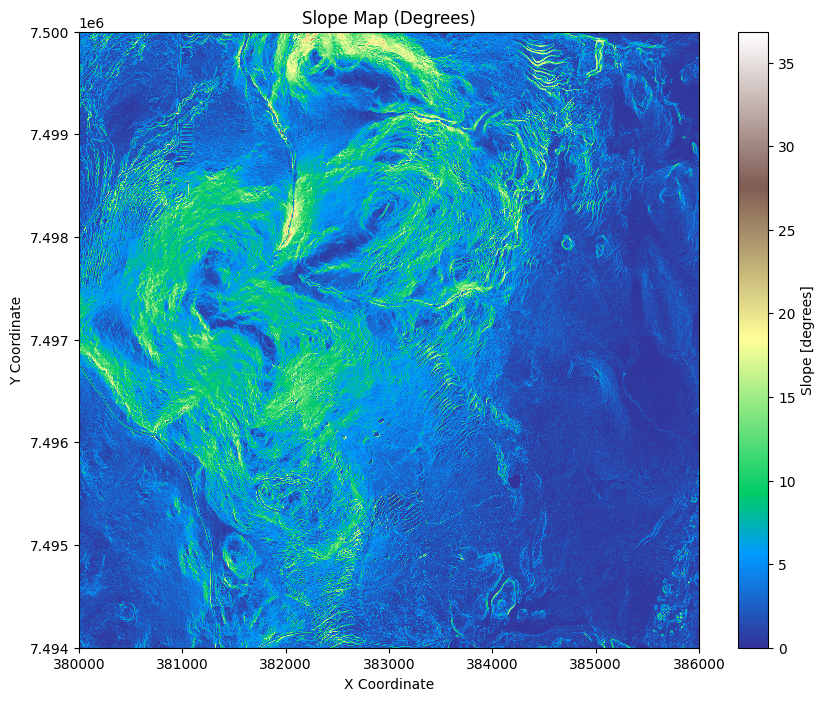

In [18]:
# Plot the slope raster
plt.figure(figsize=(10, 8))
slope.plot(cmap='terrain', add_colorbar=True)
plt.title("Slope Map (Degrees)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

### Raster-to-Raster Calculations

Raster-to-raster calculations involve performing mathematical or logical operations on two or more raster datasets to derive new information. Each raster grid cell is processed based on corresponding cells from the input rasters. This method is commonly used in geospatial analysis to perform tasks like:

- **Combining terrain attributes**: Slope, aspect, and DEM can be used to calculate terrain stability or hydrological indices.
- **Environmental modeling**: Calculating indices such as vegetation health (NDVI) using different raster bands.
- **Suitability analysis**: Combining different factors such as elevation and slope to determine land use or habitat suitability.

**Example: Slope Stability Index (SSI)**
*SSI* is a basic measure to assess the potential stability of a terrain. It combines both the slope steepness and elevation of the terrain, providing an index that indicates the likelihood of a slope to remain stable. Steeper slopes and higher elevations tend to be more prone to instability, which can lead to phenomena such as landslides, rockfalls, or soil erosion.

The Slope Stability Index can be calculated as:

$$
\text{SSI} = \frac{1}{\text{Slope} \times \text{Elevation}}
$$

- **Slope**: The steepness of the terrain, typically measured in degrees or percentage.
- **Elevation (DEM)**: The height of the terrain above a reference point (usually sea level).
- **SSI**: The lower the value of the SSI, the higher the instability risk. Conversely, higher values indicate more stable terrain.


Now let's write this in Python:

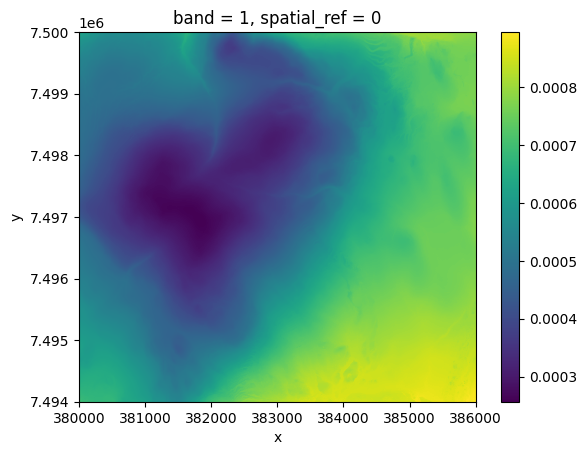

In [21]:
import numpy as np
import rioxarray as rxr

# Read the first band
slope = slope[0]
dem = yllas_dem[0]

# Avoid division by zero by setting zero or negative DEM values to NaN
dem = yllas_dem.where(dem > 0)

# Calculate the Slope Stability Index (SSI)
ssi = 1 / (slope * dem)

# Handle any infinities resulting from division by zero (set them to NaN)
ssi = ssi.where(np.isfinite(ssi), np.nan)

# Update SSI attributes to match input slope raster
ssi.rio.write_crs(slope.rio.crs)
ssi.rio.write_nodata(np.nan, inplace=True)

# Save the result as a GeoTIFF
ssi.plot()

> **Lazy Loading?**  
> If data loads poorly or improves on re-run, it’s likely due to **lazy loading**. Libraries like `xarray` defer loading large datasets until explicitly needed, and slow I/O or caching issues can result in incomplete reads. Re-running often helps.